In [1]:
!pip3 install scipy==1.2.0

     |████████████████████████████████| 26.6 MB 1.5 MB/s            
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tpot 0.11.7 requires scipy>=1.3.1, but you have scipy 1.2.0 which is incompatible.
stumpy 1.10.2 requires scipy>=1.5, but you have scipy 1.2.0 which is incompatible.
statsmodels 0.13.1 requires scipy>=1.3, but you have scipy 1.2.0 which is incompatible.
sklearn-pandas 2.2.0 requires scipy>=1.5.1, but you have scipy 1.2.0 which is incompatible.
scikit-image 0.19.1 requires scipy>=1.4.1, but you have scipy 1.2.0 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.2.0 which is incompatible.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.2.0 which is incompat

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import scipy.io
from os import listdir
from random import randint
from scipy.spatial.distance import cdist 
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import f1_score
from collections import Counter

# Read data

In [3]:
from os import listdir

def load_test_data():
    images = []
    ground_truth = []
    boundaries = []
    path_images = '../input/bsrbsds5002/BSR/BSDS500/data/images/test/'
    path_ground = '../input/bsrbsds5002/BSR/BSDS500/data/groundTruth/test/'

    images_List = listdir(path_images)
    c = 0
    for image in images_List:
      if image != "Thumbs.db":
        mat = scipy.io.loadmat(path_ground + image[:-4]) # dir path + fileName
        img = Image.open(path_images + image)
#         print(mat['groundTruth'])
#         break;
        lst = []
        lst2 = []
        images.append(np.array(img))
        for j in range(mat['groundTruth'].shape[1]):
          lst.append(mat['groundTruth'][0][j][0][0][0])
        ground_truth.append(lst)
        for j in range(mat['groundTruth'].shape[1]):
          lst2.append(mat['groundTruth'][0][j][0][0][1])
        boundaries.append(lst2)
        
    return np.array(images) , np.array(ground_truth) , np.array(boundaries)


In [4]:
images , ground_truth , boundaries = load_test_data()
print(images.shape)
print(np.array(ground_truth).shape)
print(np.array(boundaries).shape)

print(images[0].shape)
print(np.array(ground_truth[0]).shape)
print(np.array(boundaries[0]).shape)

print(images[0][0][0][0], "\n\n")
print(np.array(ground_truth)[0][0][0][5], "\n\n")
print(np.array(boundaries)[0][0][0][5], "\n\n")

(200,)
(200,)
(200,)
(321, 481, 3)
(6, 321, 481)
(6, 321, 481)
116 


1 


0 




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:
ground_truth = np.array(ground_truth)
print(images[0][0][0])
# print(ground_truth[0][0])
# for i in range(321):
#     print(ground_truth[0][0][i], "\n\n")

[116 159 194]


print(i)

# Visualize the image and the ground truth segmentation 

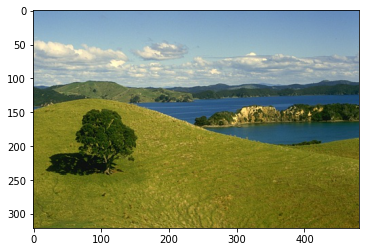

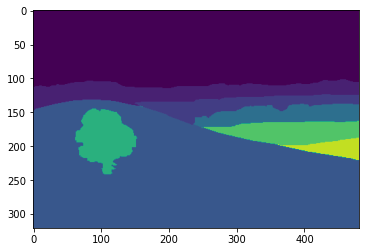

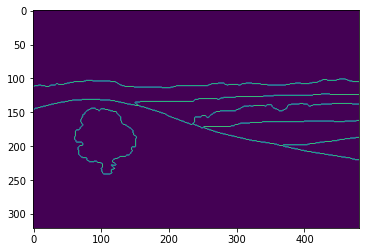

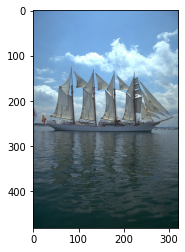

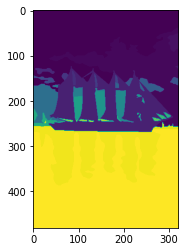

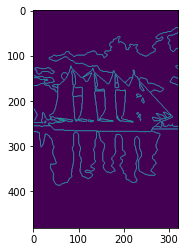

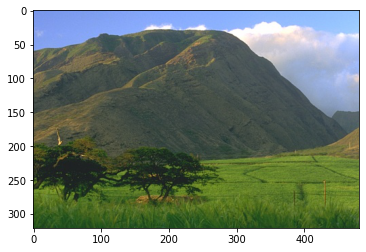

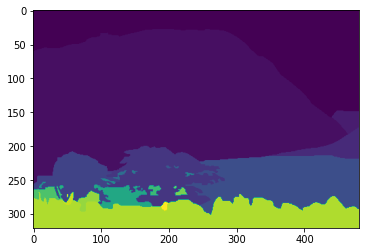

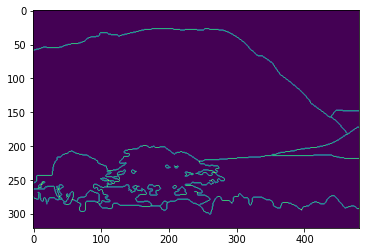

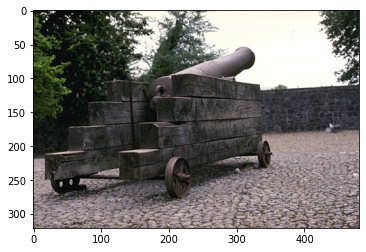

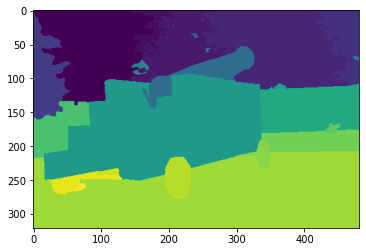

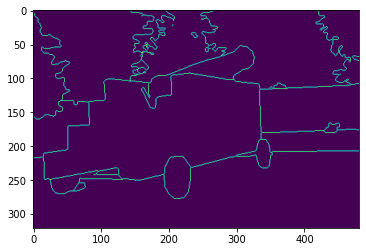

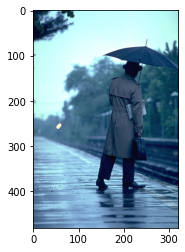

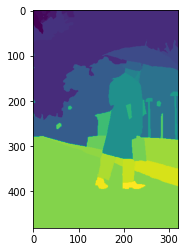

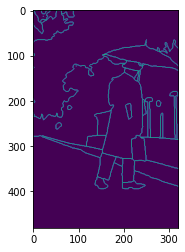

In [6]:
 for i in range(5):
    plt.figure()
    plt.imshow(images[i])
    plt.show()
    plt.figure()
    plt.imshow(ground_truth[i][0])
    plt.show()
    plt.figure()
    plt.imshow(boundaries[i][0])
    plt.show()

# Segmentation using K-means

In [7]:
#generate initial centriods
import random
def generate_centroids(k,data):
    centroids = list()
    init_centroids = random.sample(range(0, len(data)), k)
    
    for i in init_centroids:
        centroids.append(data[i])
    
    return np.array(centroids)

def cluster_assignment(centroids, data):
    assigned_centroid = []
    for i in data:
        distance=[]
        for j in centroids:
            distance.append(np.linalg.norm(i-j))
        assigned_centroid.append(np.argmin(distance))
    return assigned_centroid


def update_centroids(data,clusters):
    new_centroids = []
    new_df = pd.concat([pd.DataFrame(data), pd.DataFrame(clusters, columns=['cluster'])],
                      axis=1)
    for c in set(new_df['cluster']):
        current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    return new_centroids


def k_means(data,k):
    centroids = generate_centroids(k,data)
    clusters = cluster_assignment(centroids,data)
    for i in range(10):
        centroids = update_centroids(data,clusters)
        clusters = cluster_assignment(centroids,data)
    return np.array(centroids) ,np.array(clusters)


def k_means_seg(data,k):
    c , cl = k_means(data,k)
    img = c[cl]    
    return img, cl


In [8]:
def f_measure(data, ground_truth):
    print("vvvvvvvvvvv")
    ELEM_NUM = 1
    PARTITION_VAL = 0
    
    
    data = np.array(data)
    #data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
    ground_truth = np.array(ground_truth)
    ground_truth =  ground_truth.flatten()
    
    print(data.shape)
    print(ground_truth.shape)
    
    gd_counter = Counter(ground_truth)
    
    f_measure_val = []
    
    for cluster in np.unique(data):
        
        cluster_elements = ground_truth[np.where(data == cluster)]
        
        print(cluster_elements.shape)
        print(cluster_elements)
        
        cluster_count = Counter(cluster_elements)
        max_partition = cluster_count.most_common(1)[0]
        
        purity = max_partition[ELEM_NUM] / cluster_elements.size
        recall = max_partition[ELEM_NUM] / gd_counter[max_partition[PARTITION_VAL]]
        
        f_measure_val.append(2 * purity * recall / (purity + recall))
        
    return sum(f_measure_val) / len(f_measure_val)


In [9]:
def conditional_entropy(data, ground_truth):
    total_entropy = 0
    data = np.array(data)
    #data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
    ground_truth = np.array(ground_truth)
    ground_truth =  ground_truth.flatten()

    print(data.shape)
    print(ground_truth.shape)
    for cluster in np.unique(data):
        cluster_elements = np.asarray(
            ground_truth[np.where(data == cluster)]
        )
        elements_counter = Counter(cluster_elements)
        cluster_entropy = 0
        for partition in np.unique(ground_truth):
            prob = elements_counter[partition] / np.size(cluster_elements)
            # print(prob)
            cluster_entropy -= prob * np.log2(prob) if prob != 0 else 0
            assert np.isnan(prob) == False
            assert np.isnan(cluster_entropy) == False
        total_entropy += cluster_entropy * cluster_elements.size 
    return total_entropy / data.size

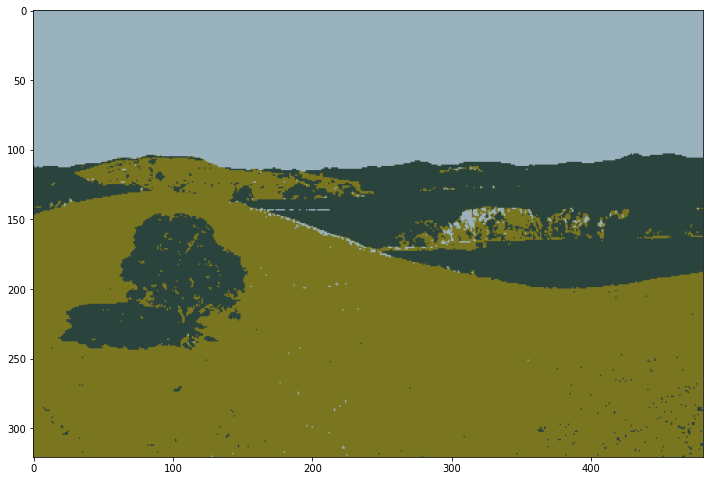

In [10]:
img = images[0].reshape((-1,3))
img, cl = k_means_seg(img, 3)
img = img.reshape((321, 481, 3))
plt.figure(figsize=(12,10))
img = np.array(img, dtype='uint8')
plt.imshow(img)
plt.show()
    

In [11]:
print(img.shape)
print(cl[0].shape)
f_measure_val = f_measure(cl, ground_truth[0][0])
print(cl[0:10])
print(ground_truth[0][0].flatten()[0:10])
print(f_measure_val)

print("\n\n\n")

e = conditional_entropy(cl, ground_truth[0][0])
print(e)


# for k in (3,5,7,9,11):
#     img = k_means_seg(images[0],k)
#     f_measure_val = f_measure(img,ground_truth[0][0])
#     print(f_measure_val)

(321, 481, 3)
()
vvvvvvvvvvv
(154401,)
(154401,)
(53456,)
[1 1 1 ... 4 4 4]
(71660,)
[2 2 2 ... 4 4 4]
(29285,)
[2 2 2 ... 4 4 4]
[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]
0.7574499708395299




(154401,)
(154401,)
0.8536289286199191


# Big Picture

Select a set of five images and display their corresponding ground truth
against your segmentation results using K-means at K=5. Comment on
the results

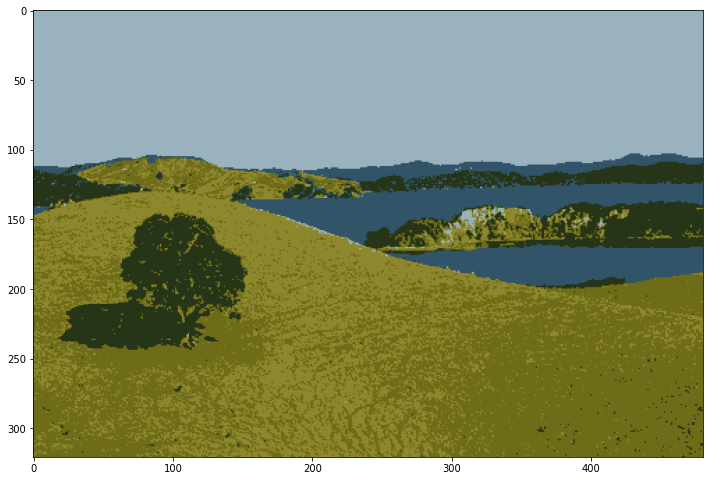

<Figure size 864x720 with 0 Axes>

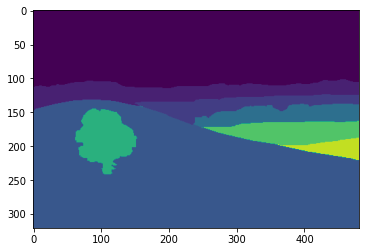

<Figure size 864x720 with 0 Axes>

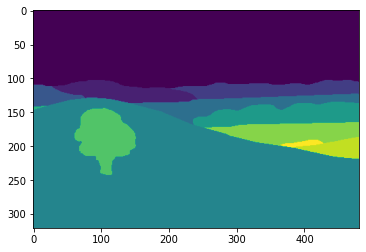

<Figure size 864x720 with 0 Axes>

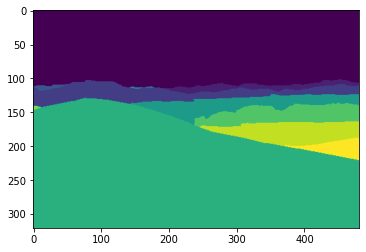

<Figure size 864x720 with 0 Axes>

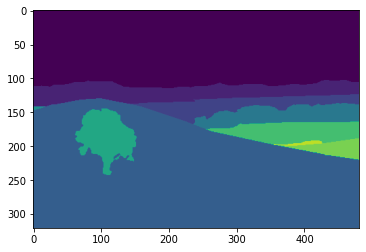

<Figure size 864x720 with 0 Axes>

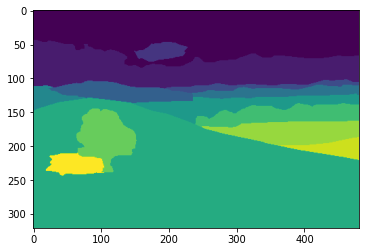

<Figure size 864x720 with 0 Axes>

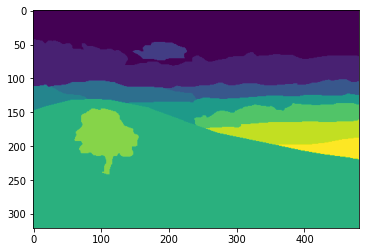

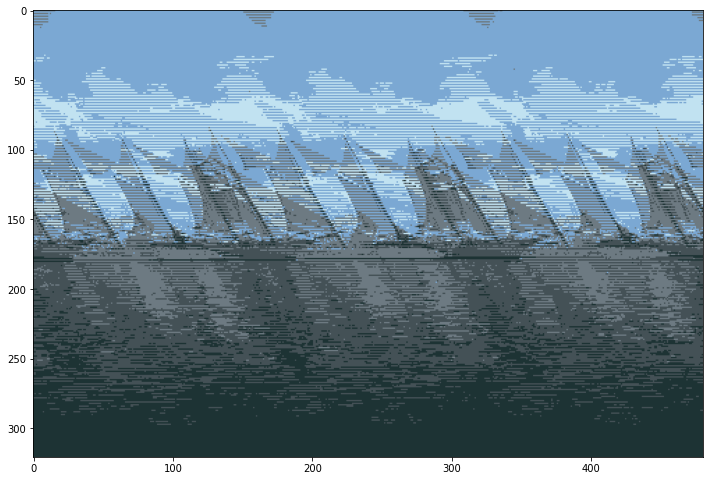

<Figure size 864x720 with 0 Axes>

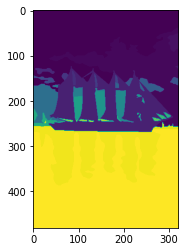

<Figure size 864x720 with 0 Axes>

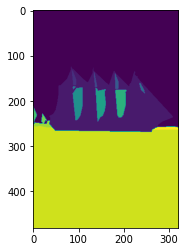

<Figure size 864x720 with 0 Axes>

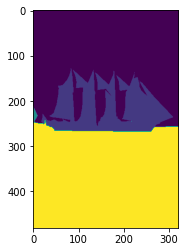

<Figure size 864x720 with 0 Axes>

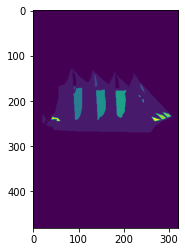

<Figure size 864x720 with 0 Axes>

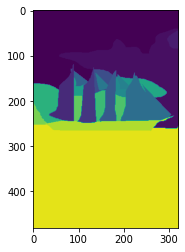

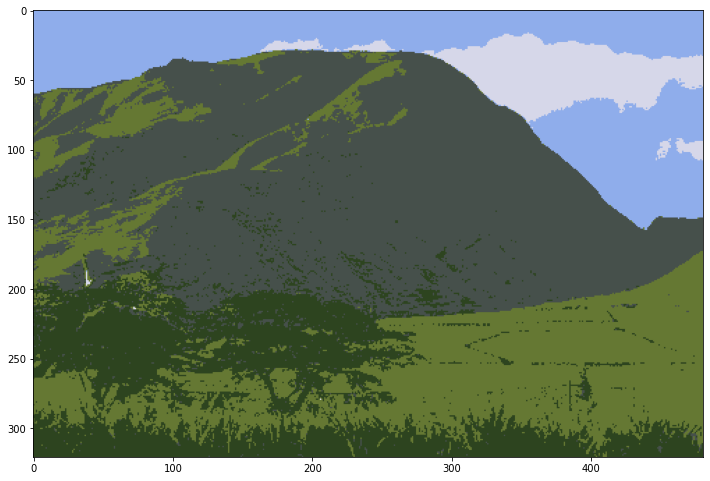

<Figure size 864x720 with 0 Axes>

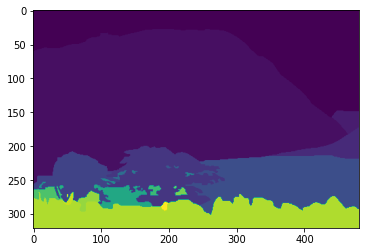

<Figure size 864x720 with 0 Axes>

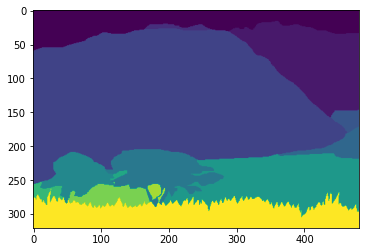

<Figure size 864x720 with 0 Axes>

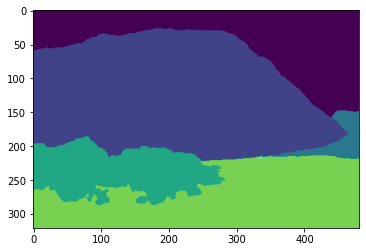

<Figure size 864x720 with 0 Axes>

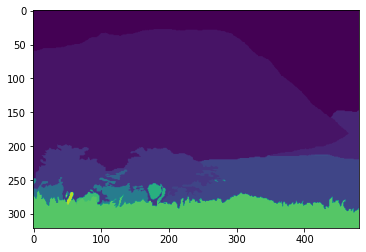

<Figure size 864x720 with 0 Axes>

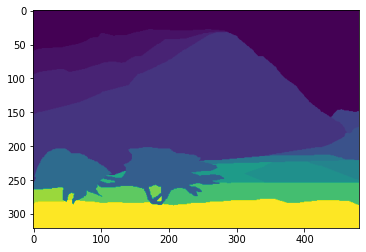

<Figure size 864x720 with 0 Axes>

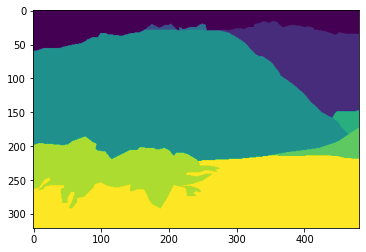

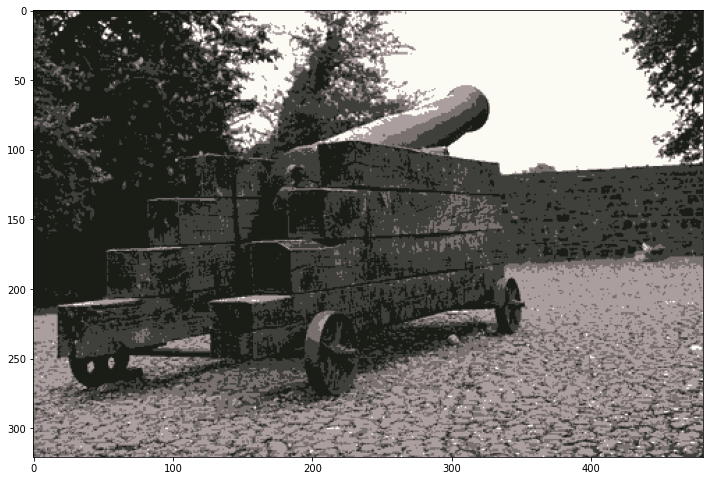

<Figure size 864x720 with 0 Axes>

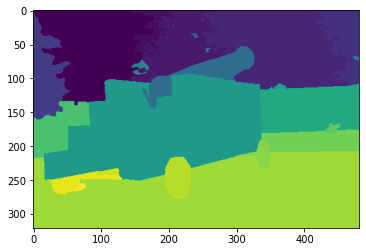

<Figure size 864x720 with 0 Axes>

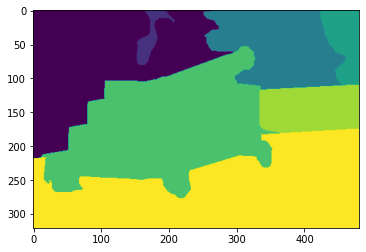

<Figure size 864x720 with 0 Axes>

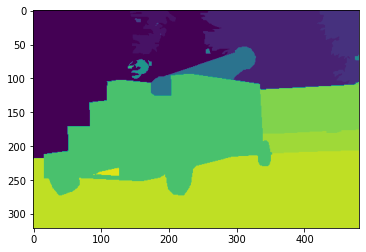

<Figure size 864x720 with 0 Axes>

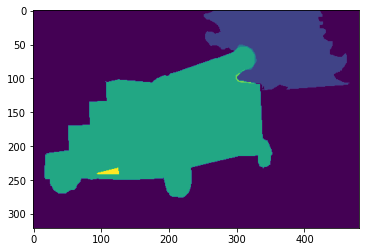

<Figure size 864x720 with 0 Axes>

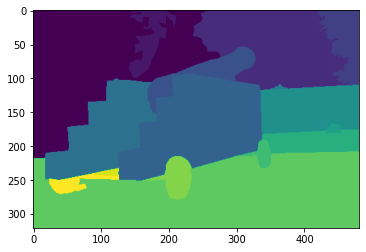

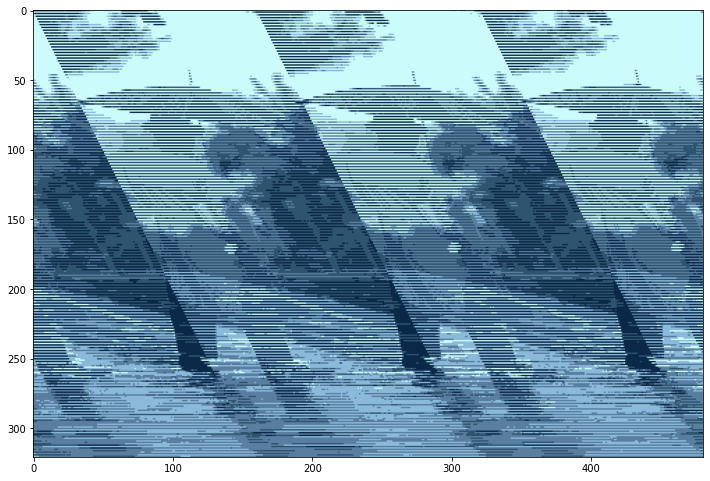

<Figure size 864x720 with 0 Axes>

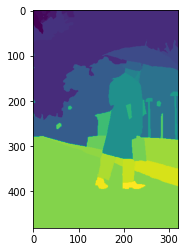

<Figure size 864x720 with 0 Axes>

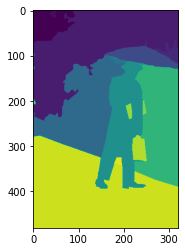

<Figure size 864x720 with 0 Axes>

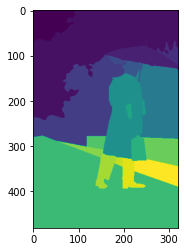

<Figure size 864x720 with 0 Axes>

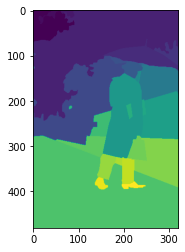

<Figure size 864x720 with 0 Axes>

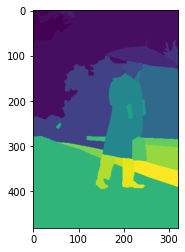

In [12]:

for i in range (5):
    img = images[i].reshape((-1,3))
    img, cl = k_means_seg(img, 5)
    img = img.reshape((321, 481, 3))
    plt.figure(figsize=(12,10))
    img = np.array(img, dtype='uint8')
    plt.imshow(img)
    plt.show()
    for j in range(len(ground_truth[i])):
        plt.figure(figsize=(12,10))
        plt.figure()
        plt.imshow(ground_truth[i][j])
        plt.show()
        

Select the same five images and display their corresponding ground
truth against your segmentation results using Normalized-cut for the 5-
NN graph, at K=5. Comment on the results****

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


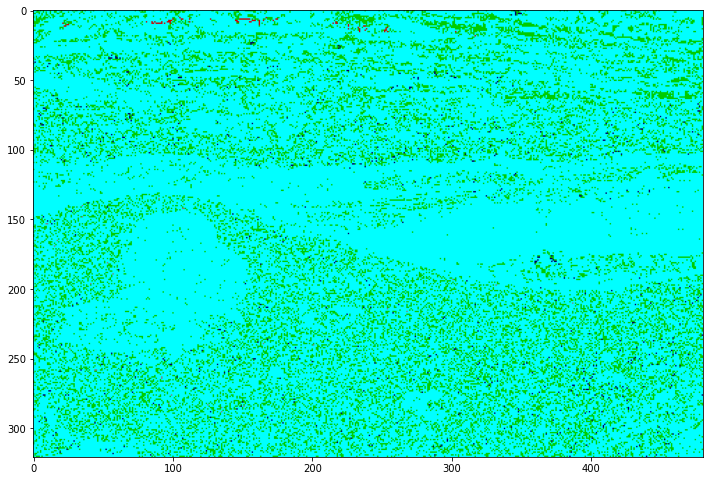

<Figure size 864x720 with 0 Axes>

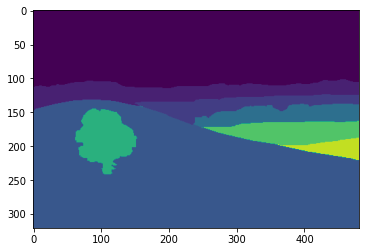

<Figure size 864x720 with 0 Axes>

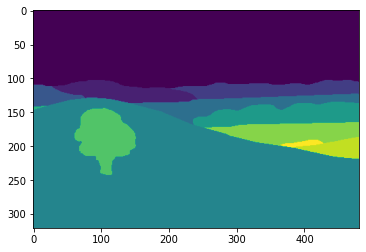

<Figure size 864x720 with 0 Axes>

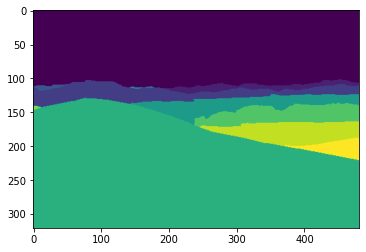

<Figure size 864x720 with 0 Axes>

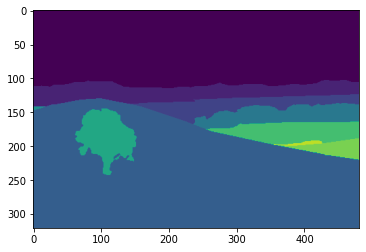

<Figure size 864x720 with 0 Axes>

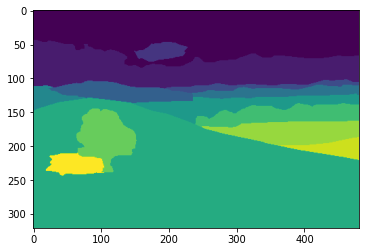

<Figure size 864x720 with 0 Axes>

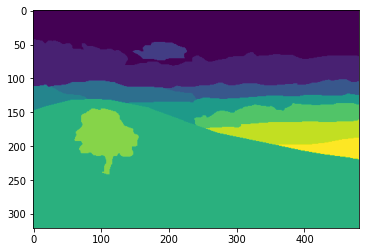

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


In [ ]:
colors=[[0,255,255],[204,0,0],[128,128,128],[0,204,0],[0,0,102]];
for i in range (5):
    img = images[i].reshape((-1,3))
    model = SpectralClustering(n_clusters=5,affinity='nearest_neighbors',n_neighbors=5,n_jobs=-1).fit_predict(img)
    new_image = []
    for x in model:
        new_image.append(colors[x])
    new_image = np.array(new_image)
    img = new_image.reshape((321, 481, 3))
    plt.figure(figsize=(12,10))
    img = np.array(img, dtype='uint8')
    plt.imshow(img)
    plt.show()
    for j in range(len(ground_truth[i])):
        plt.figure(figsize=(12,10))
        plt.figure()
        plt.imshow(ground_truth[i][j])
        plt.show()
   
        

Select the same five images and display their corresponding ground
truth against your segmentation results using Normalized-cut for the 5-
NN graph, at K=5. Comment on the results.

In [ ]:
for i in range (5):
    img = images[i].reshape((-1,3))
    img, cl = k_means_seg(img, 5)
    img = img.reshape((321, 481, 3))
    plt.figure(figsize=(12,10))
    img = np.array(img, dtype='uint8')
    plt.imshow(img)
    plt.show()
    model = SpectralClustering(n_clusters=5,affinity='nearest_neighbors',n_neighbors=5,n_jobs=-1).fit_predict(img)
    new_image = []
    for x in model:
        new_image.append(colors[x])
    new_image = np.array(new_image)
    img = new_image.reshape((321, 481, 3))
    plt.figure(figsize=(12,10))
    img = np.array(img, dtype='uint8')
    plt.imshow(img)
    plt.show()

# Extra

In [ ]:
def spacial_layout(image):
    img = np.arange(321*481*5).reshape(321*481, 5)
    count=0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            img[count] = np.append(image[i,j,:],[i,j])
            count = count +1
    return img

In [ ]:
for i in range (5):
    img = spacial_layout(images[i])
    img, cl = k_means_seg(img, 5)
    img = img.reshape((321, 481, 3))
    plt.figure(figsize=(12,10))
    img = np.array(img, dtype='uint8')
    plt.imshow(img)
    plt.show()
    for j in range(len(ground_truth[i])):
        plt.figure(figsize=(12,10))
        plt.figure()
        plt.imshow(ground_truth[i][j])
        plt.show()